# Which type of flower is it? 

The goal for this assignment to is to classify five different flowers species from a dataset sourced from kaggle (insert link) using a convolutional neural network(CNN). Since i am faced with the challenge of limited computing resources the goal is to implement different strategies to make the process efficient. 

I was initially inspired by AlexNets structure, but my goal was to make it much more simpler for my use case and also the last dense layer should output predictions for 5 classes and not 1000. The way i wanted to achive this was using the technique of "dilation convulution" early in the layer structure to create a large receptive field and catch out crude shapes and images but not having to use as much compute as by striding the traditional way. However this appeared to be a too much challenge for me in this assignment time-frame. 


-------------------

### Dataset. (Before and after dataset)
In preparing the dataset, i removed images that didn't meet the specific quality critera.

To work with processing the data is a crusial step, given the limited size of our dataset so we want every image to contribute meaningfully to the CNN. My philosophy was straightforward: If i as a human can't see what type of flower clearly it is on the pictures i will not expect the network to know or learn it either. This led to the removal of images for reasons:

* Different flower types overlapping eachother. 
* No flower in the image
* pictures taken from too far away (or too close)
* flowers of the wrong kind in the wrong folder
* indirect flowers that where seen in reflection
* flowers that where painted (kept some that where really realistic though)
* images where there where too many different types of flowers in each picture
* Withered flowers (outliers)


Dandelion was a type that excpected to be challenging because it is essentaltity two classes into one (since the flower changes so much) and it is slightly skewed since there is more pictures on when its not blooming than yellow ones (fully bloomed).



## Dataset size before:
* daisy = 764
* dandelion = 1051
* rose = 784
* sunflower = 733
* tulip = 984 

## Dataset size after:
* daisy = 742
* dandelion = 1016
* rose = 759
* sunflower = 694
* tulip = 853

Images removed = 252

As we can see the dataset is also unbalanced so i will adjust this by augmenting the pictures to the class who has the most pictures (dandelion).
This will make the dataset have approx 5000 images. 
----

In [1]:
# Importing relevant packages
import numpy as np
import matplotlib.pyplot as plt
import PIL
from pathlib import Path
import pandas as pd
import random as rand
import scipy
import datetime
import seaborn as sns


# %load_ext tensorboard

import os
import visualkeras

import tensorflow as tf
from tensorflow.keras import optimizers, losses
from tensorflow.keras.regularizers import L2



from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import Adam, Optimizer
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPool2D, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

2023-12-18 21:02:31.014109: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 5080 files belonging to 5 classes.
Using 4064 files for training.
Found 5080 files belonging to 5 classes.
Using 1016 files for validation.
After splitting validation once more:
val_split contains: 8 objects (approx 512 images) for validation
test_split contains: 8 objects (approx 512 images) for testing
Classes in the dataset are: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Dimensions for each image batch is: (64, 128, 128, 3)
Label batch size corresponding to each object: (64,)


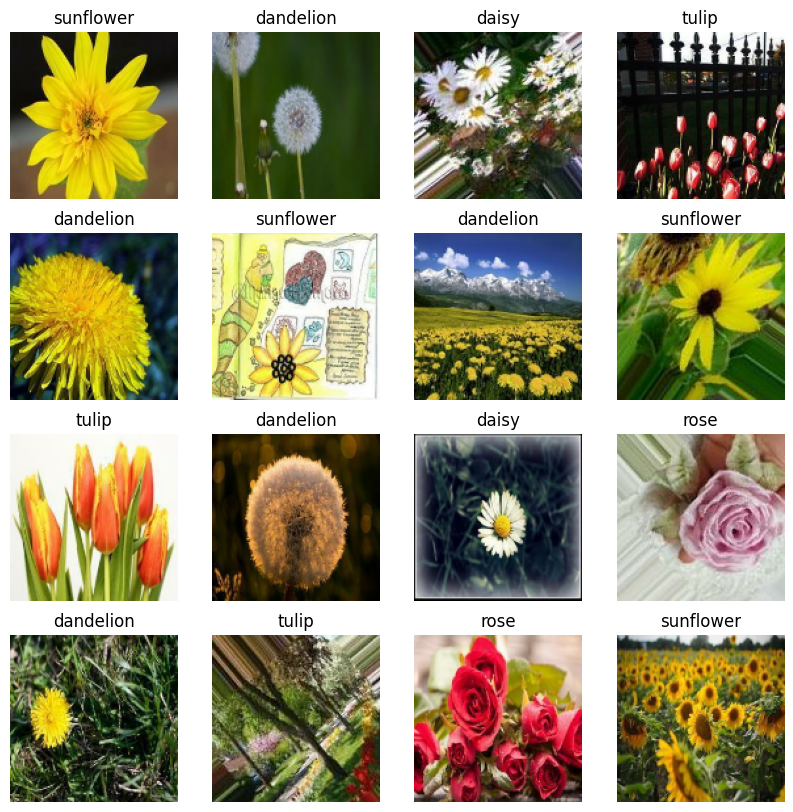

In [2]:
DATA_DIR = Path('../dl-assignment/data/flowers').with_suffix('')
WEIGHTS_PATH = Path('../dl-assignment/weights') # Path to the weights (For transfer learning)
CHECKPOINT_PATH = Path('../dl-assignment/checkpoint/')
LOGS_PATH = Path('../dl-assignment/logs/')


IMG_HEIGHT = 128
IMG_WIDTH = 128


BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2 # 20% of the data is used for validation (10 % will go to testing)
RANDOM_SEED = 137
TARGET_SIZE = (IMG_WIDTH, IMG_HEIGHT)

# Network parameters 
LEARNING_RATE = 0.0008
NUM_EPOCHS = 10


NUM_CLASSES = 5 # 5 classes in the dataset
# DROPOUT_RATE = 0.5 # How many neurons to drop in each layer

def get_separator():
    """ Returns a separator """
    print("======================================================")
    

def count_files(DATA_DIR):
    """
    Counts the number of files in DATA_DIR's subfolders
    
    returns: 
    - highest_file: The subdir the class that has the highest number of files. (Augment other classes to match "dandelion")
    - A dictionary with the subfolder name as key and the number of files as value

    """

    highest_file = 0
    subdir_file_counts = {}

    for item in os.listdir(DATA_DIR):
        path = os.path.join(DATA_DIR, item)
        if os.path.isdir(path):
            file_count = len(os.listdir(path))
            highest_file = max(highest_file, file_count)
            subdir_file_counts[item] = file_count
            # print(f'Amount of images in each class {highest_file}')

    return highest_file, subdir_file_counts

highest_file, subdir_file_counts = count_files(DATA_DIR)

# ORIGINAL FILE COUNTS
# # daisy: 743 files
# # rose: 760 files
# # tulip: 854 files
# # dandelion: 1017 files <--- This is the highest
# # sunflower: 695 files


def augment_settings():
    """
    Settings for the augmentation using ImageDataGenerator

    """

    DATAGEN = ImageDataGenerator(
        rotation_range=45,  # rotates the images
        width_shift_range=0.2, # shifts the pixels of images so it is not centered
        height_shift_range=0.2,
        horizontal_flip=True,  # Spins the images
        vertical_flip=True,
        fill_mode='nearest', # "padds the images with the nearest pixel" -> abcd becomes aaa|abcd|ddd
    )

    return DATAGEN
    
DATAGEN = augment_settings()


def augment_images_subdir(DATA_DIR, DATAGEN, highest_file, subdir_file_counts):
    """ 
    Performing augmentation on the images in subdirs 'DATA_DIR/flower/ until generated_files is equal to the highest_file
    
    """
    for subdir, file_count in subdir_file_counts.items():
        amount_to_generate = highest_file - file_count # The amount of images to generate

        if amount_to_generate > 0:
            path_sub = os.path.join(DATA_DIR, subdir)

            # iterating over each subdir and augmenting the images
            generate_data = DATAGEN.flow_from_directory(
                DATA_DIR,
                classes=[subdir],
                target_size=(IMG_HEIGHT, IMG_WIDTH),
                batch_size=1, # one image at a time
                save_to_dir=path_sub,
                save_prefix='aug',
                save_format='jpg',
            )

            print(f"Generating {amount_to_generate} images for class '{subdir}'")

            for _ in range(amount_to_generate):
                generate_data.next()

            print(f"Completed image generation for class '{subdir}'")

    return 


augment_images_subdir(DATA_DIR, DATAGEN, highest_file, subdir_file_counts)
get_separator()


def split_data():
    """
    Splits the data into train and val split and get labels for each class

    Returns: 
    - train, test, val - split
    - Visualization of train_split

    """

    train_split = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR,
        validation_split=VALIDATION_SPLIT,
        subset='training',
        seed=RANDOM_SEED,
        image_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
    )

    val_split = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR,
        validation_split=VALIDATION_SPLIT, # 10 % of the data is used for validation
        subset='validation',
        seed=RANDOM_SEED,
        image_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
    )

    # Splitting the validation data into test and validation from val_split (10% each)
    test_split_size = len(val_split) // 2
    val_split_size = len(val_split) // 2

    test_split = val_split.take(test_split_size)
    val_split = val_split.skip(test_split_size)

    get_separator()
    print(f'After splitting validation once more:\nval_split contains: {val_split_size} objects (approx 512 images) for validation')
    print(f'test_split contains: {test_split_size} objects (approx 512 images) for testing')
    get_separator()


    class_names = train_split.class_names
    print(f'Classes in the dataset are: {class_names}')
    
    return train_split, test_split, val_split, class_names

train_split, test_split, val_split, class_names = split_data()  # Accessing the data outside my function



def visualize_data(train_split):
    """"
    Visualizing the 20 images from one of the splits and output the dimensions of the images

    """

    plt.figure(figsize=(10, 10))
    for images, labels in train_split.take(1): # takes 1 batch of images
        for i in range(16):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype('int'))
            plt.title(class_names[labels[i]])
            plt.axis('off')

    for image_batch, labels_batch in train_split:
        get_separator()
        print(f'Dimensions for each image batch is: {image_batch.shape}')
        print(f'Label batch size corresponding to each object: {labels_batch.shape}')
        break
    plt.show()



visualize_data(train_split)

Normalization (min-max feature scaling)
###  $X' = \frac{X-X_{\min}}{X_{max}-X_{min}}$

In [3]:
# TODO: Might need to rescale the pixel values to [-1 , 1]  depending on its activation function


def normalize_data(train_split, test_split, val_split):
    """
    Normalizes the data with tensorflow by dividing each pixel by 255 (max value of a pixel)

    Returns: normalized train, test, validation split rescaled

    """
    norm_train_split = train_split.map(lambda x, y: (x / 255.0, y))
    norm_test_split = test_split.map(lambda x, y: (x / 255.0, y))
    norm_val_split = val_split.map(lambda x, y: (x / 255.0, y))


    # Looping through (once) the normalized dataset to see if it is normalized for both train and validation split
    for img_,  labels_ in norm_train_split:
        break
    
    for img__, labels__ in norm_test_split:
        break

    for img___, labels___ in norm_val_split:
        break

    
    # First image in the first batch
    first_imgTRAIN = img_[0]
    first_imgTEST = img__[0]
    first_imgVAL = img___[0]

    print(f'After applying Normalization the pixel values of the first train img is between: {np.min(first_imgTRAIN), np.max(first_imgTRAIN)}')
    print(f'After applying Normalization the pixel values of the first test img is between: {np.min(first_imgTEST), np.max(first_imgTEST)}')
    print(f'After applying Normalization the pixel values of the first validation img is between: {np.min(first_imgVAL), np.max(first_imgVAL)}')


    return norm_train_split, norm_test_split, norm_val_split



norm_train_split, norm_test_split, norm_val_split = normalize_data(train_split, test_split, val_split)

get_separator()
# -> returns None in shape to indicate that the batch size can be any size  
print(f'Normalized Train Split Shape: {norm_train_split.element_spec}')
print(f'Normalized Test Split Shape: {norm_test_split.element_spec}')
print(f'Normalized Validation Split Shape: {norm_val_split.element_spec}') 


get_separator()
# Gives me the amount of tensors stored as a list in both datasets (train and validation)
print(f'Amount of tensors in train set: {len(list(norm_train_split))}')  
print(f'Amount of tensors in test set: {len(list(norm_test_split))}')  
print(f'Amount of tensors in validation set: {len(list(norm_val_split))}')

After applying Normalization the pixel values of the first train img is between: (0.0, 1.0)
After applying Normalization the pixel values of the first test img is between: (0.016167495, 1.0)
After applying Normalization the pixel values of the first validation img is between: (0.0, 1.0)
Normalized Train Split Shape: (TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Normalized Test Split Shape: (TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Normalized Validation Split Shape: (TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Amount of tensors in train set: 64
Amount of tensors in test set: 8
Amount of tensors in validation set: 8


# Building CNN

###  Why did you chose your model architechture and the choise of relevant hyperparamaters?
    - The architecture consists of two convolutional layers followed by a max-pooling layer. The choice of 32 and 64 is because it is common in these kinds of architectures and since the image was 128x128x3 it seemed like a even choice because all are even numbers.

    - Kernel size: 3x3 because of small sized images

    - Activation function: I used ReLU since the nice speed boost it gives compared to sigmoid or tanh. 

    - Pooling: Used to downsample the spatial dimensions.

    - Loss function: I choose sparse categorical crossentropy as loss function because it is a multi class-classification problem

    - Fully connected layers: Two fully connected with dropout to prevent overfitting (model to specialized on training data)

    - Regularization technique: I Chose L2 since everyone says, use L2. TODO: TEST L1 

### NOTE: If the code is outcommented it is because i have been tweaking the cnns layers 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 128)               8

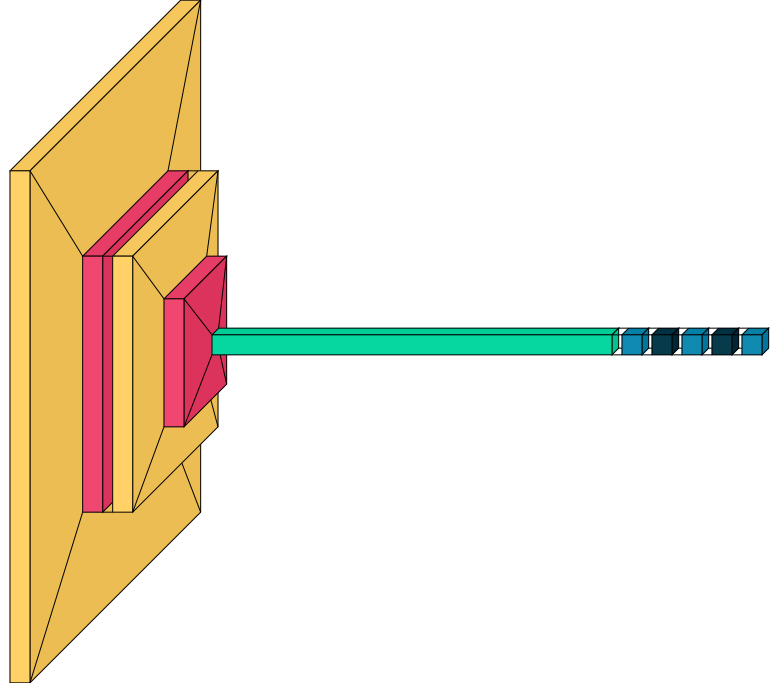

In [4]:
def build_cnn():
    """
    Building the CNN model
    
    Returns: model

    """
    model = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        MaxPool2D(pool_size=(2, 2)),
        Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=L2(1e-3)),
        MaxPool2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=L2(1e-3)),
        Dropout(rate=0.5),
        Dense(32, activation='relu', kernel_regularizer=L2(1e-3)),
        Dropout(rate=0.3),

        Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # logits true: because model output needs to be normalized to calculate the loss
        metrics=['accuracy']
    )

    model.summary()

    return model


model = build_cnn()

visualkeras.layered_view(model)


In [5]:

##### SAME MODEL AS ABOVE BUT WITH ONE LESS FULLY CONNECTED DENSE LAYER

# def build_cnn2():
#     """
#     THIS IS THE SAME MODEL AS ABOVE BUT WITH A ONE LESS FULLY CONNECTED LAYER

#     """
#     model = Sequential([
#         Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
#         MaxPool2D(pool_size=(2, 2)),
#         Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=L2(1e-3)),
#         MaxPool2D(pool_size=(2, 2)),
#         Flatten(),
#         Dense(128, activation='relu', kernel_regularizer=L2(1e-3)),
#         Dropout(rate=0.5),
#         Dense(NUM_CLASSES, activation='softmax')
#     ])

#     model.compile(
#         optimizer=Adam(learning_rate=LEARNING_RATE),
#         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # logits true: because model output needs to be normalized to calculate the loss
#         metrics=['accuracy']
#     )

#     model.summary()

#     return model


# model = build_cnn2()

# visualkeras.layered_view(model)


# Train model

In [6]:
def train_model(model, norm_train_split, norm_val_split, weights_path=None):
    """"
    This script trains the model and saves the weights and history.

    If a path to saved weights is provided, it loads those weights before training.

    """

    AUTOTUNE = tf.data.AUTOTUNE #  optimize the data loading
    norm_train_split = norm_train_split.cache().prefetch(buffer_size=AUTOTUNE)
    norm_val_split = norm_val_split.cache().prefetch(buffer_size=AUTOTUNE)


    # #  Load weights if path is provided (to continue training from a checkpoint)
    # if weights_path:
    #     model.load_weights(weights_path)
    #     print(f'Loaded weights from: {weights_path}')

    
    checkpoint = ModelCheckpoint(filepath=CHECKPOINT_PATH / 'model-{epoch:02d}-{val_loss:.2f}-{accuracy:.2f}.h5',
                                monitor='val_accuracy', # Good metric to balance since if this doesn't follow the training accuracy, model might overfit
                                save_weights_only=True,
                                save_best_only=True,
                                verbose=1
                                )
    
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1) # Stops training if no significant improvement is made


    get_separator()
    print('Starting training........')
    get_separator()

    history = model.fit(
        norm_train_split,
        epochs=NUM_EPOCHS,
        validation_data=norm_val_split,
        callbacks=[checkpoint, early_stopping],
        )
    
    
    def save_history(history):
        time = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
        file = (f'history_{NUM_EPOCHS}_{time}.npy')
        file = os.path.join(LOGS_PATH, file)

        
        # Create logs folder if it does not exist
        if not LOGS_PATH.exists:
            os.makedirs('logs')


        np.save(file, history.history) # saves history as a dict with key values

        model.save('model/model_1.h5')  #TODO generalize this solution
        
        # np.save('logs/history.npy', history.history)
        
        get_separator()
        print(f'Saved training history to: {file}')
        get_separator()


    return history, save_history(history)


# weights_path = 'path/to/your/saved/weights.h5'  # Replace with your actual file path

train_model(model, norm_train_split, norm_val_split)


Starting training........
Epoch 1/10


/Users/joeloscarsson/Documents/www/dl-assignment/dlassignment/lib/python3.9/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


64/64 [==============================] - ETA: 0s - loss: 1.9487 - accuracy: 0.3194
Epoch 1: val_accuracy improved from -inf to 0.46627, saving model to ../dl-assignment/checkpoint/model-01-1.59-0.32.h5
64/64 [==============================] - 52s 787ms/step - loss: 1.9487 - accuracy: 0.3194 - val_loss: 1.5901 - val_accuracy: 0.4663
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 1.5291 - accuracy: 0.4409
Epoch 2: val_accuracy improved from 0.46627 to 0.54563, saving model to ../dl-assignment/checkpoint/model-02-1.39-0.44.h5
64/64 [==============================] - 43s 674ms/step - loss: 1.5291 - accuracy: 0.4409 - val_loss: 1.3926 - val_accuracy: 0.5456
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 1.3992 - accuracy: 0.4877
Epoch 3: val_accuracy improved from 0.54563 to 0.57341, saving model to ../dl-assignment/checkpoint/model-03-1.29-0.49.h5
64/64 [==============================] - 46s 714ms/step - loss: 1.3992 - accuracy: 0.4877 - val_loss: 

/Users/joeloscarsson/Documents/www/dl-assignment/dlassignment/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved training history to: ../dl-assignment/logs/history_10_2023-12-18_21-10-18.npy


(<keras.src.callbacks.History at 0x15ee46a30>, None)

# Evaluate trainings

* Overall i think my CNN model is training fast with the data i have so that is one goal achieved and that is training on my old mac computer
    * This changes of course with how many parameters my CNN has but the big things is that each image is not huge in size which helps a lot.

In [7]:
df = pd.DataFrame(np.load('logs/history_25_2023-12-18_18-04-20.npy', allow_pickle=True).item())


df.sort_values(by=['val_accuracy'], ascending=False)

,loss,accuracy,val_loss,val_accuracy
19,0.751967,0.871063,1.400312,0.656746
23,0.715938,0.889764,1.575556,0.652778
20,0.741500,0.874754,1.472295,0.652778
18,0.782342,0.853839,1.339638,0.652778
14,0.831240,0.817175,1.318545,0.646825
24,0.702652,0.896900,1.593532,0.642857
22,0.720407,0.879429,1.563505,0.642857
21,0.757109,0.870817,1.492229,0.642857
17,0.797055,0.843996,1.353181,0.642857
12,0.924067,0.774606,1.238918,0.640873


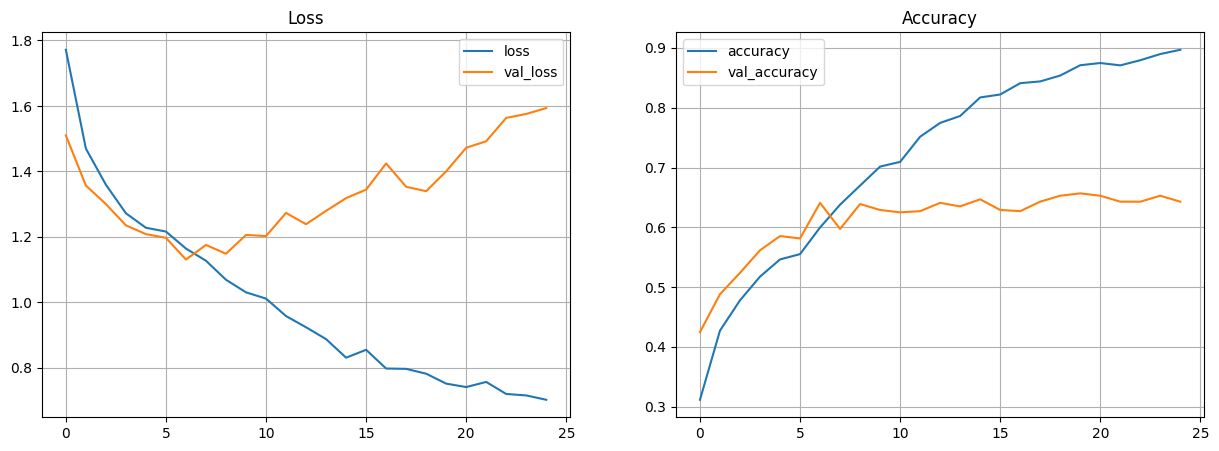

In [8]:

# Plots metrics over training history
def plot_metrics(metrics):
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    metrics[['loss', 'val_loss']].plot(ax=ax[0], title='Loss', grid=True)
    metrics[['accuracy', 'val_accuracy']].plot(ax=ax[1], title='Accuracy', grid=True) 

plot_metrics(df)


First graph (Loss)
* The val_loss is increasing while loss is decreasing.
* It seems like the model is starting to have the tendency to overfit around 5 epochs in on the data
    * TODO: Test weights from model at around 7 epoch

Accuracy graph

* Around epoch 6-8 it the val_acc is starting to plateau and it suggest that beyond these epochs the model is not getting better at the validation and only learns the data by heart. That is why accuracy is still increasing.

Possible ways going forward:
* Even though i have worked with the dataset i am still not so sure the image quality is diverse inside each class. 
* Tune hyperparameters and try to combat overfitting the data
* Take a look at example images that where classified wrong to get a feel for what types of shapes the model has a hard time learning

----------------------

In [9]:
df2 = pd.DataFrame(np.load('logs/history_15_2023-12-18_19-16-31.npy', allow_pickle=True).item())
df2.sort_values(by=['val_loss'], ascending=True)

,loss,accuracy,val_loss,val_accuracy
6,0.987906,0.699311,1.177987,0.636905
3,1.174787,0.589813,1.187079,0.613095
5,1.032004,0.673228,1.226725,0.609127
2,1.249050,0.549459,1.235052,0.593254
4,1.090453,0.638041,1.240013,0.601190
10,0.845250,0.774360,1.262874,0.607143
1,1.390104,0.473671,1.268479,0.581349
7,0.956209,0.713337,1.271576,0.621032
8,0.919224,0.738435,1.310290,0.585317
9,0.894904,0.759104,1.325905,0.579365


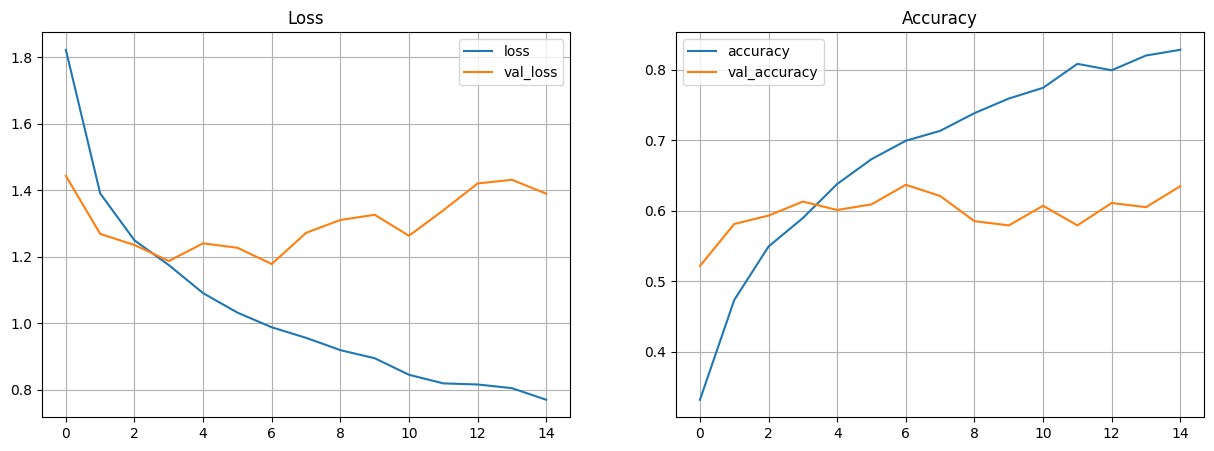

In [10]:
df2 = pd.DataFrame(np.load('logs/history_15_2023-12-18_19-16-31.npy', allow_pickle=True).item())

plot_metrics(df2)

Here i changed the CNN to have one less fully connected layer

First graph (Loss)
* The model seems to overfit again at epoch 5ish

Accuracy graph

* Training accuracy is increasing which is good but val_accuracy seem to fluctuate

# Evaluate performance on test split

2/2 [==============================] - 0s 81ms/step
Accuracy for the test data: 0.656%


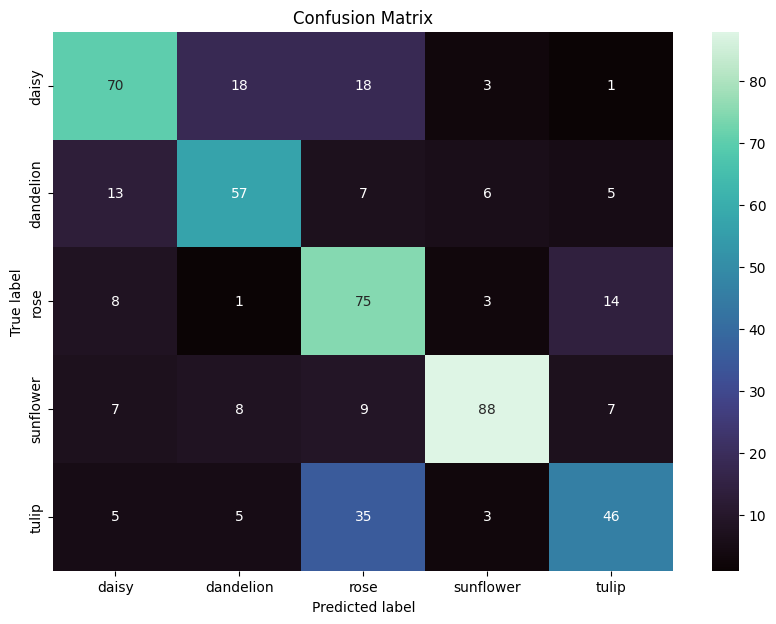

array([[70, 18, 18,  3,  1],
       [13, 57,  7,  6,  5],
       [ 8,  1, 75,  3, 14],
       [ 7,  8,  9, 88,  7],
       [ 5,  5, 35,  3, 46]])

In [11]:
from sklearn.metrics import confusion_matrix

##TODO: Here have the weights from the best model and run predict on the test_split e.g 

# load in the best model. 
model = load_model('model/model_1.h5')


def cm_matrix(norm_test_split, title='Confusion Matrix'):
    """
    Plotting the confusion matrix and predicting on normalized test_split

    Returns: Confusion Matrix, Accuracy for the test split

    """

    labels = []
    predictions = []


    for image_batch, labels_batch in norm_test_split:
        batch_predictions = model.predict(image_batch)
        labels_pred = np.argmax(batch_predictions, axis=-1)

        
        # one-hot encoding
        if isinstance(labels_batch, np.ndarray): 
            labels_true = np.argmax(labels_batch, axis=-1) # if labels is numpy array convert to ints
        else:
            labels_true = labels_batch.numpy() # otherwise then convert to np array


        # extends the list by appending from iterable
        predictions.extend(labels_pred)
        labels.extend(labels_true)


    CM = confusion_matrix(labels, predictions)


    accuracy = np.trace(CM) / np.sum(CM)
    print(f"Accuracy for the test data: {accuracy:.3f}%")

    plt.figure(figsize=(10,7))
    sns.heatmap(CM, annot=True,
                fmt='d',
                cmap='mako',
                xticklabels=class_names,
                yticklabels=class_names
                )
    
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(title)
    plt.show()

    return CM

cm_matrix(norm_test_split)


incorrect = [
    (example, class_names[prediction])
    for example, prediction, is_correct in zip(test_batch, test_prediction, correct_predicate)
    if not is_correct
]
display_images(
  [(get_image(example), "prediction: {0}\nlabel:{1}".format(incorrect_prediction, get_class(example)))
   for (example, incorrect_prediction) in incorrect[:20]])


# TODO: Takeaway

# Transfer learning

I will use the ResNet50 for transfer learning

In [21]:

from tensorflow.keras.applications import ResNet50
import tensorflow_hub as hub


import ssl
ssl._create_default_https_context = ssl._create_unverified_context



# Loads the model with pre trained weights
MODEL = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    pooling='avg',
    classes=NUM_CLASSES,

)
# MODEL.save('model/resnet50.h5')
# base_cnn=load_model('weights.h5')


feature_extractor = tf.layers(MODEL, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))


# freeze the layer
feature_extractor.trainable = False

model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.summary()


model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)




AttributeError: module 'tensorflow' has no attribute 'layers'